## 1. Data Loading

In [1]:
import pickle

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS   = 950

# Load the pickle file
print("Loading datafile...")
with open("mon_standard.pkl", 'rb') as fi:
    data = pickle.load(fi)

X1 = [] # Array to store instances (timestamps) - 19,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2 = [] # Array to store instances (direction*size) - size information
y = [] # Array to store the site of each instance - 19,000 instances, e.g., [0, 0, 0, 0, 0, 0, ..., 94, 94, 94, 94, 94]

# Differentiate instances and sites, and store them in the respective x and y arrays
# x array (direction*timestamp), y array (site label)
for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE # Calculate which site's URL the current URL being processed belongs to and set that value as the label. Thus, URLs fetched from the same site are labeled identically.
    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1.append(time_seq)
        X2.append(size_seq)
        y.append(label)
size = len(y)

print(f'Total samples: {size}') # Output: 19000


Loading datafile...
Total samples: 19000


## 2. Feature Engineering

In [2]:
import numpy as np
from itertools import groupby

# Initialize a list to store all features
features = []

# Feature extraction
for i in range(len(X2)):
    size_seq = X2[i]
    time_seq = X1[i]
    
    # 1. Number of incoming packets
    num_incoming_packets = sum(1 for size in size_seq if size < 0)
    
    # 2. Total number of packets
    num_total_packets = len(size_seq)
    
    # 3. Number of outgoing packets
    num_outgoing_packets = sum(1 for size in size_seq if size > 0)
    
    # 4. Proportion of outgoing packets
    ratio_outgoing = num_outgoing_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 5. Proportion of incoming packets
    ratio_incoming = num_incoming_packets / num_total_packets if num_total_packets > 0 else 0
    
    # 6. Proportion of incoming packets in the first 30 packets
    incoming_first_30 = sum(1 for size in size_seq[:30] if size < 0) / 30 if num_total_packets >= 30 else 0
    
    # 7. Proportion of outgoing packets in the first 30 packets
    outgoing_first_30 = sum(1 for size in size_seq[:30] if size > 0) / 30 if num_total_packets >= 30 else 0
    
    # 8. Maximum number of packets in outgoing bursts
    burst_outgoing_max = max(len(list(g)) for k, g in groupby(size_seq) if k > 0) if num_outgoing_packets > 0 else 0
    
    # 9. Standard deviation of outgoing burst sizes
    outgoing_burst_std = np.std([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 10. Average size of outgoing bursts
    outgoing_burst_avg = np.mean([len(list(g)) for k, g in groupby(size_seq) if k > 0])
    
    # 11. Number of outgoing bursts
    num_outgoing_bursts = len([1 for k, g in groupby(size_seq) if k > 0])
    
    # 12. Number of incoming bursts
    num_incoming_bursts = len([1 for k, g in groupby(size_seq) if k < 0])
    
    # 13. Average number of incoming packets per second
    incoming_per_second_avg = num_incoming_packets / (len(time_seq) / 60) if len(time_seq) > 0 else 0

    # 14. Total transmission time
    total_time = sum(time_seq)

    # 15. Average time interval in the last 5 seconds
    last_5_seconds_time_intervals = np.mean([time_seq[i+1] - time_seq[i] for i in range(len(time_seq)-1) if time_seq[i] > 0]) if len(time_seq) > 1 else 0
    
    # 16. Sum of packet sizes
    sum_packets = sum(size_seq)
    
    # 17. Packets per second
    packets_per_second = len(size_seq) / sum(time_seq) if sum(time_seq) > 0 else 0
    
    # 18. Mean packets per second
    packets_per_second_values = [1 / t for t in time_seq if t > 0]
    
    # 19. mean of the packets per second values
    mean_packets_per_second = np.mean(packets_per_second_values) if packets_per_second_values else 0
    
    # 20. Standard deviation of packets per second
    std_packets_per_second = np.std(packets_per_second_values) if packets_per_second_values else 0
    
    # 21. Transmission time Q1 (25th percentile)
    transmission_time_Q1 = np.percentile(time_seq, 25) if len(time_seq) > 0 else 0
    
    # 22. Transmission time Q2 (median)
    transmission_time_Q2 = np.percentile(time_seq, 50) if len(time_seq) > 0 else 0
    
    # 23. Transmission time Q3 (75th percentile)
    transmission_time_Q3 = np.percentile(time_seq, 75) if len(time_seq) > 0 else 0
    
    # 24. Transmission time Q4 (maximum)
    transmission_time_Q4 = np.percentile(time_seq, 100) if len(time_seq) > 0 else 0
    
    # 25. Average ordering of outgoing packets
    outgoing_order = [i for i, size in enumerate(size_seq) if size > 0]
    average_outgoing_ordering = np.mean(outgoing_order) if outgoing_order else 0
    
    # 26. Standard deviation of outgoing packet ordering
    std_dev_outgoing_ordering = np.std(outgoing_order) if outgoing_order else 0
    
    # Add all features to the list
    features.append([
        num_incoming_packets, num_total_packets, num_outgoing_packets, ratio_outgoing,
        ratio_incoming, incoming_first_30, outgoing_first_30, burst_outgoing_max,
        outgoing_burst_std, outgoing_burst_avg, num_outgoing_bursts,
        num_incoming_bursts, incoming_per_second_avg,  total_time,
        last_5_seconds_time_intervals, 
        sum_packets, packets_per_second, mean_packets_per_second, std_packets_per_second,
        transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4,
        average_outgoing_ordering, std_dev_outgoing_ordering
    ])

# Convert the feature list to a numpy array
features = np.array(features)

# Labels for each sample
y = np.array(y)


## 3. Data Splitting and Scaling

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Train the Extra Tree model

In [4]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(
    n_estimators=110,
    max_depth=35,
    max_features=0.5,
    random_state=42
)

et_model.fit(X_train, y_train)

ExtraTreesClassifier(max_depth=18, max_features=0.5, n_estimators=350,
                     random_state=42)

## 5. Model Evaluation

In [5]:
from sklearn.metrics import accuracy_score, auc,roc_auc_score, confusion_matrix, precision_score, precision_recall_curve, roc_curve, recall_score, f1_score, classification_report, average_precision_score
from sklearn.preprocessing import label_binarize

y_pred = et_model.predict(X_test)

# Calculate Accuracy, Precison, Recall, F1 Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate Macro ROC AUC
y_test_bin = label_binarize(y_test, classes=np.arange(95))  
y_scores = et_model.predict_proba(X_test) 
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

roc_auc_macro = np.mean(list(roc_auc.values()))

# Calculate Macro PR AUC
n_classes=95
pr_auc_per_class = []
for i in range(n_classes): 
    pr_auc = average_precision_score(y_test == i, y_scores[:, i])
    pr_auc_per_class.append(pr_auc)
macro_pr_auc = np.mean(pr_auc_per_class)

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(95)])

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Weighted): {precision:.4f}")
print(f"Recall (Weighted): {recall:.4f}")
print(f"F1 Score (Weighted): {f1:.4f}")
print(f"Macro-average ROC AUC: {roc_auc_macro:.4f}")
print(f"Macro-average PR AUC: {macro_pr_auc : .4f}")

print(f"\nConfusion Matrix\n{conf_matrix}")
print("\nClassification Report:\n", class_report)

Accuracy: 0.8066
Precision (Weighted): 0.8096
Recall (Weighted): 0.8066
F1 Score (Weighted): 0.8043
Macro-average ROC AUC: 0.9835
Macro-average PR AUC:  0.8695

Confusion Matrix
[[20  0  0 ...  0  0  0]
 [ 0 34  0 ...  0  0  0]
 [ 0  0 37 ...  0  0  0]
 ...
 [ 0  0  0 ... 26  0  1]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 28]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.83      0.50      0.62        40
     Class 1       0.89      0.85      0.87        40
     Class 2       0.93      0.93      0.93        40
     Class 3       0.82      0.90      0.86        40
     Class 4       0.74      0.85      0.79        40
     Class 5       0.87      0.85      0.86        40
     Class 6       0.76      0.88      0.81        40
     Class 7       0.83      0.97      0.90        40
     Class 8       0.85      0.82      0.84        40
     Class 9       0.74      0.85      0.79        40
    Class 10       0.94      0.78      0.85   

## 6. Visualizing Results


### 6.1 Macro-average PR Curve

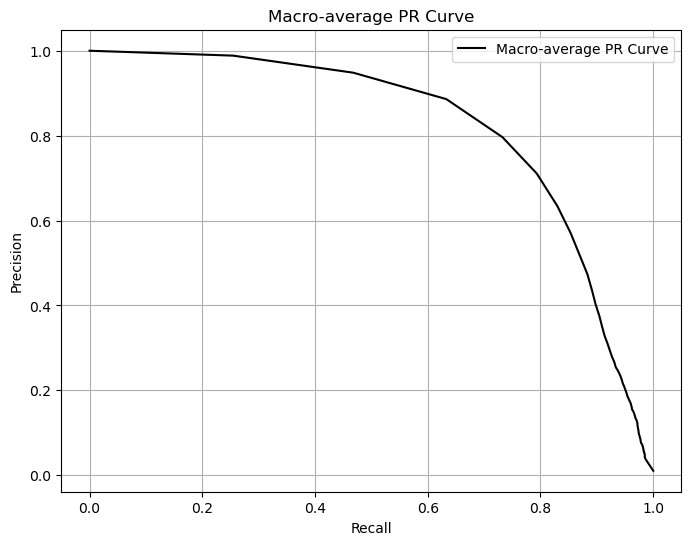

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

y_scores = et_model.predict_proba(X_test)
precision_macro = []
recall_macro = []

min_len = min([len(precision_recall_curve(y_test == i, y_scores[:, i])[0]) for i in range(n_classes)])

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    
    if len(precision) > min_len:
        precision = np.interp(np.linspace(0, 1, min_len), np.linspace(0, 1, len(precision)), precision)
        recall = np.interp(np.linspace(0, 1, min_len), np.linspace(0, 1, len(recall)), recall)
    
    precision_macro.append(precision)
    recall_macro.append(recall)

avg_precision = np.mean(precision_macro, axis=0)
avg_recall = np.mean(recall_macro, axis=0)

# Macro-average PR Curve
plt.figure(figsize=(8, 6))
plt.plot(avg_recall, avg_precision, label='Macro-average PR Curve', color='black')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-average PR Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### 6.2 Precision-Recall Curve per class

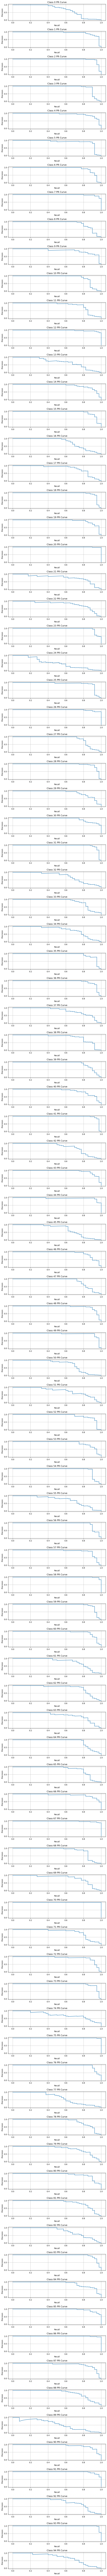

Macro-average PR AUC: 0.8694745430472495
PR AUC for each class: [0.6770928766649703, 0.9382558073594076, 0.9666115546608528, 0.9085314791594485, 0.932572786641444, 0.8878388443816562, 0.9110681515840576, 0.9856837960631056, 0.8743217353539682, 0.8767788717021622, 0.8721425442508167, 0.8318934003780949, 0.9812178928213817, 0.6760345644948473, 0.9097388280670986, 0.9368763130358156, 0.7494068402739245, 0.8138428838728659, 0.9453828492985028, 0.9323045201407032, 0.9974663235245713, 0.7652268238056026, 0.8051805692550502, 0.9612198268638431, 0.5023412829806468, 0.9093276450762432, 0.982766357970543, 0.8459046182528015, 0.9489542713992211, 0.8781820851859691, 0.9318027284438709, 0.9619107686327699, 0.7308059943905574, 0.8429073408620125, 0.7591098347333115, 0.9254151633051704, 0.9347095956152502, 0.8043438627138144, 0.8380824859086087, 0.8929105949994576, 0.8823590087285702, 0.9672933159523307, 0.7513981295462084, 0.9438897656564934, 0.9593585884691531, 0.6933837798376047, 0.910297065006352

In [8]:
n_classes = 95
fig, axes = plt.subplots(n_classes, 1, figsize=(8, 2*n_classes))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    axes[i].plot(recall, precision)
    axes[i].set_title(f'Class {i} PR Curve')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

pr_auc_per_class = []
for i in range(n_classes): 
    pr_auc = average_precision_score(y_test == i, y_scores[:, i])
    pr_auc_per_class.append(pr_auc)

macro_pr_auc = np.mean(pr_auc_per_class)

print(f"Macro-average PR AUC: {macro_pr_auc}")
print(f"PR AUC for each class: {pr_auc_per_class}")

### 6.3 Top 10 Precision-Recall Curve

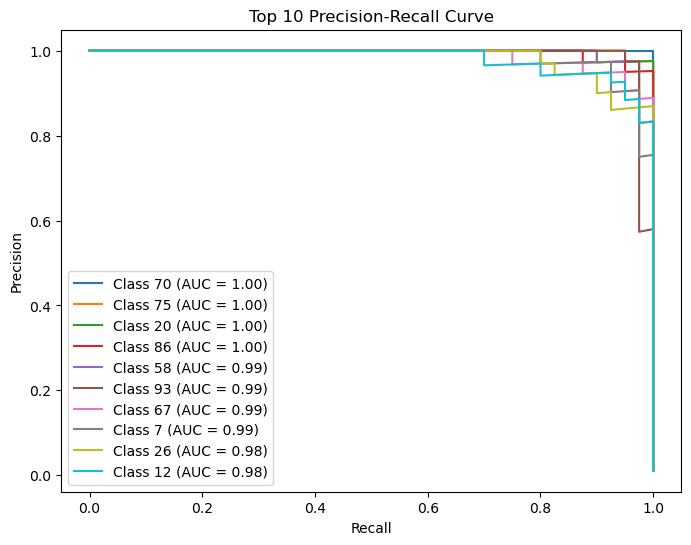

In [9]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_test, y_scores, n_classes, top_n=10):
    plt.figure(figsize=(8, 6))
    
    # Calculate AUC values and visualize only the top_n classes with the highest AUC
    auc_scores = []
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
        pr_auc = auc(recall, precision)
        auc_scores.append((i, pr_auc))
    
    # Sort classes by AUC in descending order
    auc_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Visualize only the top N classes
    for i, _ in auc_scores[:top_n]:
        precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f'Class {i} (AUC = {pr_auc:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Top {top_n} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

y_scores = et_model.predict_proba(X_test)
plot_precision_recall_curve(y_test, y_scores, 95, top_n=10)  # Visualize only the top 10 classes


### 6.4 Performance at Different Threshold

Best threshold based on F1 score: 0.30000000000000004
Precision: 0.8862359682649259
Recall: 0.7642105263157895
F1 Score: 0.8107250354039223


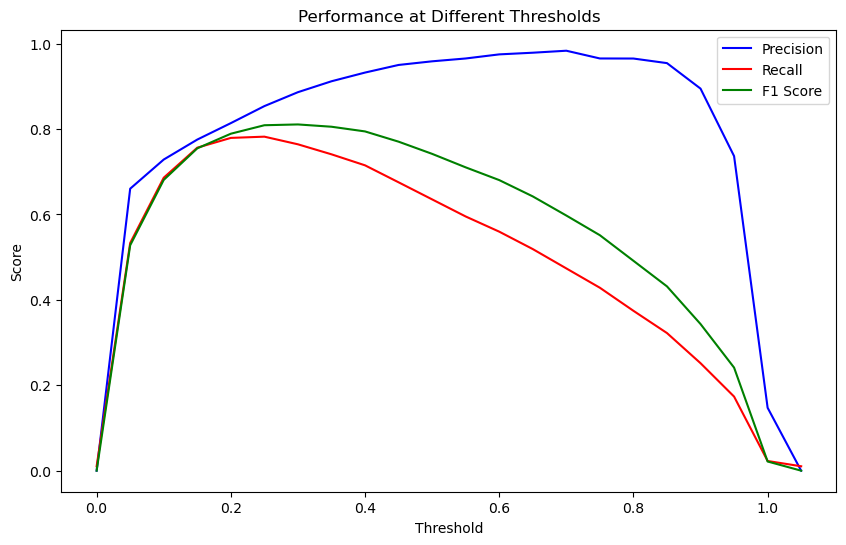

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def plot_threshold_performance(y_test, y_scores):
    thresholds = np.arange(0.0, 1.1, 0.05)  # Set thresholds from 0 to 1 with a step of 0.05 as an example
    
    precision_vals = []
    recall_vals = []
    f1_vals = []
    
    # Calculate model performance for each threshold
    for threshold in thresholds:
        # For each class, choose the class with the highest probability above the threshold
        y_pred = np.argmax(y_scores >= threshold, axis=1)  # Set to 1 if score is above threshold, otherwise 0
        precision_vals.append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        recall_vals.append(recall_score(y_test, y_pred, average='weighted'))
        f1_vals.append(f1_score(y_test, y_pred, average='weighted'))
        
    # 1. Optimal threshold
    best_threshold = thresholds[np.argmax(f1_vals)]  # Select the threshold with the highest F1 score
    print("Best threshold based on F1 score:", best_threshold)
    
    # 2. Select the class if its predicted probability exceeds the threshold
    # y_scores contains the predicted probabilities for each class, so compare with the threshold to decide the prediction
    y_pred = np.argmax(y_scores >= best_threshold, axis=1) 
    
    # 3. Calculate performance metrics using the final predictions
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision_vals, label='Precision', color='b')
    plt.plot(thresholds, recall_vals, label='Recall', color='r')
    plt.plot(thresholds, f1_vals, label='F1 Score', color='g')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Performance at Different Thresholds')
    plt.legend(loc='best')
    plt.show()

# Get predicted probabilities from the model and call the visualization function
y_scores = et_model.predict_proba(X_test)  # Get predicted probabilities
plot_threshold_performance(y_test, y_scores)


### 6.5 ROC Curve

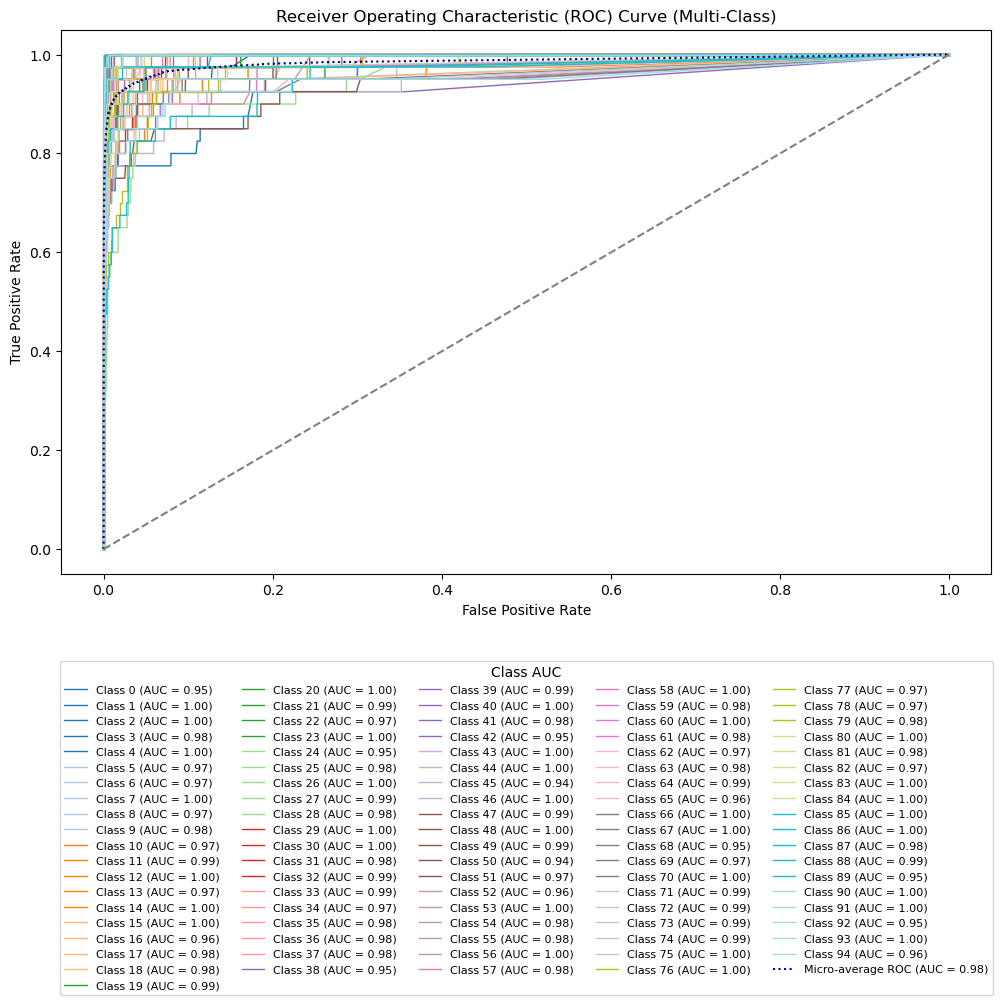

Macro-average AUC: 0.98
Micro-average AUC: 0.98


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Binarize y_test using the One-vs-Rest approach for multi-class ROC
y_test_bin = label_binarize(y_test, classes=np.arange(95))  # Binarize the 95 classes
y_scores = et_model.predict_proba(X_test)  # Get predicted probabilities for each class

n_classes = y_test_bin.shape[1]

# Calculate ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])  # Compute FPR and TPR for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute the AUC for each class

# Micro-Averaging
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_scores.reshape(-1, n_classes).ravel())  # Flatten for micro-average
roc_auc_micro = auc(fpr_micro, tpr_micro)  # Compute the micro-average AUC

# Macro-Averaging
roc_auc_macro = np.mean(list(roc_auc.values()))  # Calculate the macro-average AUC

# ROC Curve visualization
plt.figure(figsize=(12, 8))

# Plot ROC Curve for each class
colors = plt.cm.get_cmap('tab20', n_classes)  # Use different colors for the 95 classes

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=1, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot Micro-Averaging ROC Curve
plt.plot(fpr_micro, tpr_micro, color='navy', linestyle=':', label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})')

# Plot Macro-Averaging ROC Curve
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random prediction line

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Multi-Class)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, title="Class AUC", fontsize=8)
plt.subplots_adjust(bottom=0.2)
plt.show()

# Print AUC values
print(f'Macro-average AUC: {roc_auc_macro:.2f}')
print(f'Micro-average AUC: {roc_auc_micro:.2f}')
